# 📘 Causal Framework — Experiment Notebook  
*aka “let’s teach nutrition to behave causally”*

![loading gif](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNnE3YzQ5ZTMyYmY1cWJtMGRiNncxbzJwODF0YWpwbHkwdjR2dGEweiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/12cYyFxlbIgXeg/giphy.gif)

This notebook runs the full causal inference pipeline used to estimate quasi-causal effects of nutritional exposures on next-night sleep. 
It performs propensity score estimation, IPW trimming/weighting, bootstrap ATE computation, and ASMD balance diagnostics

<div style="border-bottom:1px solid #ccc; margin:20px 0;"></div>

### Before You Run (IMPORTANT!!)
Go to **`helpers/variables.py`** and configure your world:

- `DATAFRAME_PATH` → where your dataset lives  
- exposure, outcome, and confounder lists  
- `BASE_CONFIG` → the master settings object  

Nothing will run properly until this part is set

<div style="border-bottom:1px solid #ccc; margin:20px 0;"></div>

### What You Control in This Notebook
Edit these:

- `EXPOSURES` — which exposure(s) to analyze  
- `ALPHA_GRID`, `QUANTILE_GRID`, `CLIPPING_GRID` — hyperparameter grids for the search  

That’s it

The notebook will do the rest on autopilot:  
grid search → causal estimation → plots → logs → saved results in `experiment/results/`

<div style="border-bottom:1px solid #ccc; margin:20px 0;"></div>

Happy causal-ing ✨ 

In [1]:
import warnings
from dataclasses import replace

warnings.filterwarnings("ignore")

import numpy as np

from helpers.helpers import run_experiment
from helpers.propensity import get_propensity_scores
from helpers.variables import *

# Test

In [2]:
print(BASE_CONFIG)

ExperimentConfig(n_iter=2000, n_features=10, calibration='calibrated_scores_logreg', q=0.01, t='treated', stabilize=True, clip=(1, 99), alpha=0.01, method='gb')


In [3]:
exposure = 'night_fat_g_target_day'


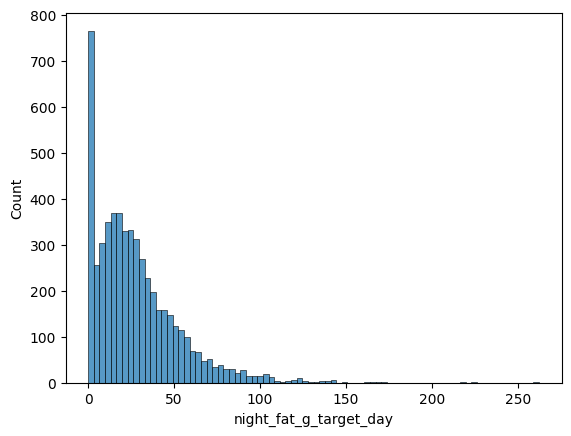

None
n=5395	min=0.0; max=262.3344332373142	after cutoff n=2693;	min=0.0; max=262.3344332373142


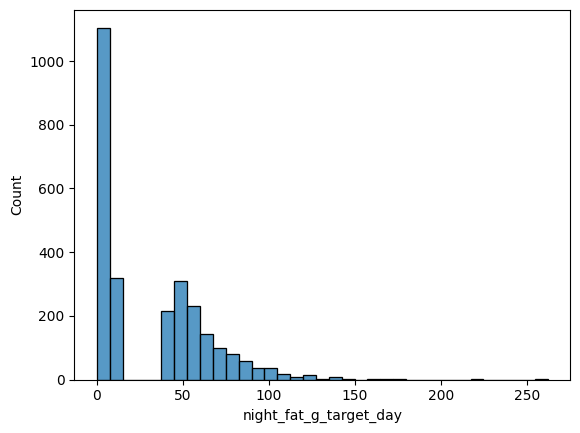

Accuracy Score=0.693


In [4]:
kwargs_assignment = {
    'cutoff_values' : None,
    'rdi_values' : None, #[300, 300],
    'q' : 0.25,
}

df, kwargs, X, shap_values = get_propensity_scores(
    exposure=exposure,
    config=BASE_CONFIG.__dict__,
    variables=variable_config,
    file=DATAFRAME_PATH,
    method="quantile",
    kwargs_assignment=kwargs_assignment,
)

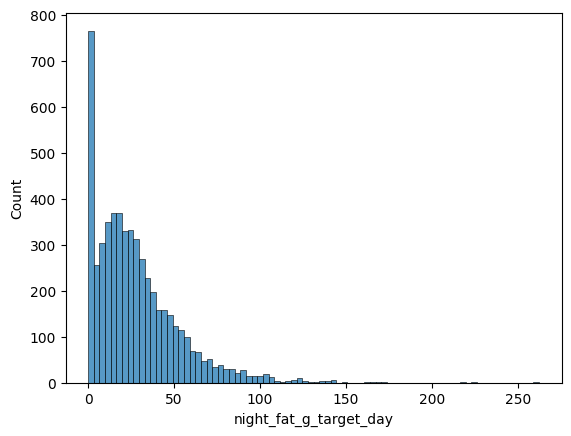

[0, 150]
n=5388	min=0.0; max=262.3344332373142	after cutoff n=5388;	min=0.0; max=148.6674948978424


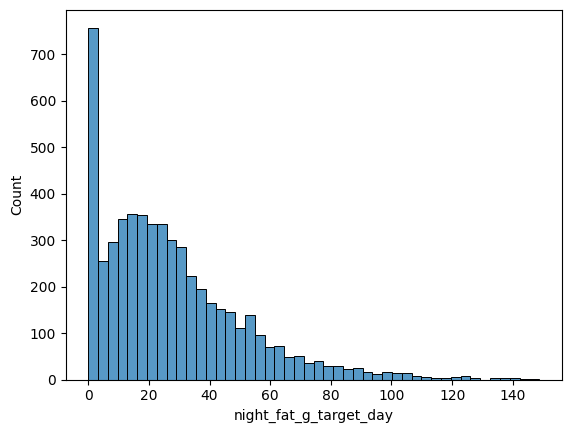

Accuracy Score=0.616


In [5]:
kwargs_assignment = {
    'cutoff_values' : [0, 150],
    'rdi_values' : [25, 30], #[300, 300],
    'q' : None,
}

df, kwargs, X, shap_values = get_propensity_scores(
    exposure=exposure,
    config=BASE_CONFIG.__dict__,
    variables=variable_config,
    file=DATAFRAME_PATH,
    method="rdi",
    kwargs_assignment=kwargs_assignment,
)

# Working notebook

In [ ]:
# ================================================================
# Hyperparameter grids
# ================================================================

ALPHA_GRID = np.array([1e-5, 0.01, 0.025, 0.05, 0.07])
QUANTILE_GRID = np.array([0.005, 0.01, 0.015, 0.025, 0.05])
CLIPPING_GRID = [None, (1, 99), (2.5, 97.5)]

EXPOSURES = [ 
    "night_fat_g_target_day"
] # Should contain "_target_day" in their naming

# ================================================================
# Grid search loop
# ================================================================

for exposure in EXPOSURES:
    for alpha in ALPHA_GRID:

        cfg = replace(
            BASE_CONFIG,
            alpha=float(alpha),
        )

        # ---- propensity score estimation ----
        df, kwargs, X, shap_values = get_propensity_scores(
            exposure=exposure,
            config=cfg.__dict__,
            variables=variable_config,
            file=DATAFRAME_PATH,
            method="median",
            cutoff_values=None,
        )

In [2]:
# ================================================================
# Hyperparameter grids
# ================================================================

ALPHA_GRID = np.array([1e-5, 0.01, 0.025, 0.05, 0.07])
QUANTILE_GRID = np.array([0.005, 0.01, 0.015, 0.025, 0.05])
CLIPPING_GRID = [None, (1, 99), (2.5, 97.5)]

EXPOSURES = [ 
    "night_fat_g_target_day"
] # Should contain "_target_day" in their naming

# ================================================================
# Grid search loop
# ================================================================

for exposure in EXPOSURES:
    for alpha in ALPHA_GRID:

        cfg = replace(
            BASE_CONFIG,
            alpha=float(alpha),
        )

        # ---- propensity score estimation ----
        df, kwargs, X, shap_values = get_propensity_scores(
            exposure=exposure,
            config=cfg.__dict__,
            variables=variable_config,
            file=DATAFRAME_PATH,
            method="median",
            cutoff_values=None,
        )
        
        for q in QUANTILE_GRID:
            for clip in CLIPPING_GRID:
                # Create a new config instance instead of mutating dicts
                cfg = replace(
                    cfg,
                    q=float(q),
                    clip=clip
                )
                
                # ---- full causal experiment ----
                summary = run_experiment(
                    config=cfg.__dict__,
                    variable_config=variable_config,
                    df=df,
                    kwargs=kwargs,
                    X=X,
                    shap_values=shap_values,
                )

Accuracy Score=0.627
[exp_id=29] exposure=night_fat_g | all_bal_0.10=71.4% | struct_bal_0.05=33.3% (unbal=2) | neg_controls_sig=0
[exp_id=30] exposure=night_fat_g | all_bal_0.10=75.0% | struct_bal_0.05=33.3% (unbal=2) | neg_controls_sig=0
[exp_id=31] exposure=night_fat_g | all_bal_0.10=85.7% | struct_bal_0.05=33.3% (unbal=2) | neg_controls_sig=0
[exp_id=32] exposure=night_fat_g | all_bal_0.10=85.7% | struct_bal_0.05=33.3% (unbal=2) | neg_controls_sig=0
[exp_id=33] exposure=night_fat_g | all_bal_0.10=89.3% | struct_bal_0.05=33.3% (unbal=2) | neg_controls_sig=0
[exp_id=34] exposure=night_fat_g | all_bal_0.10=92.9% | struct_bal_0.05=66.7% (unbal=1) | neg_controls_sig=0
[exp_id=35] exposure=night_fat_g | all_bal_0.10=92.9% | struct_bal_0.05=66.7% (unbal=1) | neg_controls_sig=0
[exp_id=36] exposure=night_fat_g | all_bal_0.10=92.9% | struct_bal_0.05=66.7% (unbal=1) | neg_controls_sig=0
[exp_id=37] exposure=night_fat_g | all_bal_0.10=100.0% | struct_bal_0.05=100.0% (unbal=0) | neg_controls_si